# Building custom graphs - Car routing

In the previous section, we learned some basic tricks how to do routing with Python.  

Now we will learn how to build a custom NetworkX graph from scratch using Digiroad street network data (national road dataset for Finland).

We will again follow the same steps that we described in previous tutorial, i.e. we will:

 1. **Retrieve data** 
 2. **Modify the network** by applying custom edge weights considering traffic conditions for car.
 3. **Build a routable graph** for NetworkX (plus there is a example how to do this for iGraph as well)
 4. **Conduct network analysis** 

### 1. Retrieve the Digiroad data

Digiroad data is openly available from [digiroad.fi](https://aineistot.vayla.fi/digiroad/) website (operated by Väylä). I have included a small GeoPackage in this repository (data/test_Digiroad.gpkg) that we can use now. If you want to download your own data, you want to use the K-format of the Digiroad data (in better format for routing). Digiroad releases the datasets in Shapefile format in regional level, and as a GeoPackage covering the whole Finland. We will use here a subset of the dataset convering the whole Finland (in GeoPackage format). 

In the data, we are primarily interested in three separate datasets:
 
  - `DR_LINKKI_K` (the edges = most important dataset)
  - `DR_NOPEUSRAJOITUS_K` (speed limit information)
  - `DR_LIIKENNEVALO` (traffic lights)

- Let's read the test dataset

In [14]:
import geopandas as gpd
import networkx as nx
import osmnx as ox

# Filepath 
fp = "data/test_Digiroad.gpkg"

# In the GeoPackage there are three layers (we are interested in all of them)
links = gpd.read_file(fp, layer='DR_LINKKI_K')
speedlimits = gpd.read_file(fp, layer='DR_NOPEUSRAJOITUS_K')
signals = gpd.read_file(fp, layer='DR_LIIKENNEVALO')

Okay, now we have read all the required datasets, let's take a quick look what they contain.

#### Input data: Links

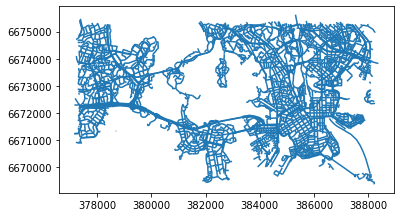

In [2]:
# Check links
links.plot()

In [3]:
links.head(2)

,LINK_ID,LINK_MMLID,SEGM_ID,KUNTAKOODI,HALLINN_LK,TOIMINN_LK,LINKKITYYP,TIENUMERO,TIEOSANRO,SILTA_ALIK,...,SIJ_TARK,KOR_TARK,ALKU_PAALU,LOPP_PAALU,GEOM_FLIP,LINK_TILA,GEOM_LAHDE,MTK_TIE_LK,TIEN_KASVU,geometry
0,139126,895321107,49_15,49,99,8,8,NaN,NaN,0.0,...,5000.0,201.0,0.0,167.437,0.0,NaN,1,12314,NaN,"LINESTRING Z (377900.004 6673387.863 16.695, 3..."
1,139127,779750930,49_22,49,99,8,8,NaN,NaN,0.0,...,3000.0,201.0,0.0,211.145,0.0,NaN,1,12314,NaN,"LINESTRING Z (377877.949 6673378.988 16.962, 3..."


#### Input data: Speedlimits

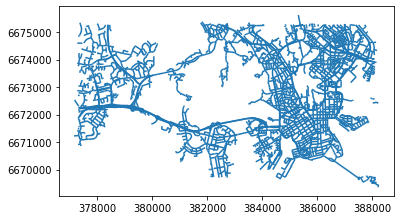

In [4]:
speedlimits.plot()

In [5]:
speedlimits.head(2)

,SEGM_ID,ID,LINK_ID,KUNTAKOODI,ALKU_M,LOPPU_M,MUOKKAUSPV,VAIK_SUUNT,ARVO,geometry
0,49_30,21836422,139128,49,0.0,164.442,20.02.2017 10:54:50,1,40,"LINESTRING Z (377887.602 6673382.772 0.000, 37..."
1,91_360,1097963,439280,91,0.0,74.324,12.06.2015 11:54:48,1,20,"LINESTRING Z (386045.354 6675208.523 0.000, 38..."


#### Input data: Traffic lights

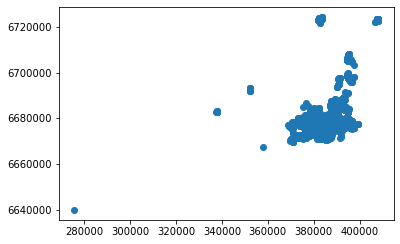

In [6]:
signals.plot()

In [7]:
signals.head(2)

,ID,LINK_ID,KUNTAKOODI,SIJAINTI_M,MUOKKAUSPV,geometry
0,10916316,345415,78,97.496,12.08.2017 19:30:23,POINT Z (275510.443 6640039.535 0.000)
1,10921363,606377,106,4.644,18.01.2016 17:38:49,POINT Z (381747.170 6723143.628 0.000)


### 2. Modify the street network - Apply intersection delays

Next we want to modify our street network a bit by calculating drivethrough times for each road segment and apply a so called intersection delay model for the road network, that makes the drive times more realistic by taking into account traffic conditions at different times of the day (see Jaakkola 2013).

We can do this by importing and using a function from our toolset called `apply_intersection_delays`. This tool does various things and we do not have time to go through the model, but basically what it does, is that it adds additional delays to roads that are affected by different type of intersections. These delays are based on floating car measurements (GPS tracks).  

In [8]:
from tools import apply_intersection_delays
help(apply_intersection_delays)

Help on function apply_intersection_delays in module tools.intersection_delay_model:

apply_intersection_delays(links, limits, signals)
    Calculate intersection delays for Digiroad network.
    
    Parameters
    ----------
    
    links : gpd.GeoDataFrame
      GeoDataFrame containing Digiroad layer 'DIGIROAD_LINKKI_K'
    limits : gpd.GeoDataFrame
      GeoDataFrame containing Digiroad layer 'DIGIROAD_NOPEUSRAJOITUS_K'
    signals : gpd.GeoDataFrame
      GeoDataFrame containing Digiroad layer 'DIGIROAD_LIIKENNEVALO'



As we can see, this tool requires that you have three datasets (mentioned above) as GeoDataFrames and you pass them into the function `apply_intersection_delays`. As a result you get the modified street network (GeoDataFrame) with drive through-times:

In [9]:
dr_data = apply_intersection_delays(links, speedlimits, signals)

Specify speed limits ..
Generate graph..
Lasted 0.9 seconds
Detect traffic lights ..
Detect slip roads ..
Detect other edges ..
Calculate drive through times using intersection penalties ..


In [10]:
# What did we get?
dr_data.head(2)

,LINK_ID,LINK_MMLID,SEGM_ID,KUNTAKOODI,HALLINN_LK,TOIMINN_LK,LINKKITYYP,TIENUMERO,TIEOSANRO,SILTA_ALIK,...,Pituus,Digiroa_aa,jtype1,jtype2,jtype3,jtype4,jtype5,Kokopva_aa,Keskpva_aa,Ruuhka_aa
0,139126,895321107,49_15,49,99,8,8,NaN,NaN,0.0,...,167.436614,2.511549,0.0,1.0,0.0,0.0,1.0,2.511549,2.511549,2.511549
1,139127,779750930,49_22,49,99,8,8,NaN,NaN,0.0,...,211.145236,3.167179,0.0,1.0,0.0,0.0,1.0,3.167179,3.167179,3.167179


Great! As a result, we now have GeoDataFrame with few new attributes that we can use for routing:

 - `Pituus` = length in meters
 - `Digiroa_aa` = drive through time based on speed limits only
 - `Kokopva_aa`= drive through time following average traffic conditions (whole day)
 - `Keskpva_aa`= drive through time following midday traffic conditions 
 - `Ruuhka_aa`= drive through time following rush hour traffic conditions 

### 3. Build the graph

Next, we want to build a graph from this data. For convenience, I have written a function called `build_graph_from_Digiroad` (in tools/graphio.py) that we can straight away use to build the graph (at the end of this notebook, we go through the logic how the graphs are built). 

- Let's first import it, and see how it should be used

In [11]:
from tools import build_graph_from_Digiroad

# Print the "manual"
help(build_graph_from_Digiroad)

Help on function build_graph_from_Digiroad in module tools.graphio:

build_graph_from_Digiroad(gdf, direction='AJOSUUNTA', both_ways=2, against=3, along=4)
    Creates a NetworkX MultiDiGraph from Digiroad 2.0 road network GeoDataFrame.
    
    Parameters
    ----------
    
    gdf : GeoDataFrame
        GeoDataFrame containing Digiroad 2.0 road network data.
    
    direction : str
        Name for column that contains information about the allowed driving directions
    
    both_ways : int
        Value specifying that the road is drivable to both directions.
    
    against : int
        Value specifying that the road is drivable against the digitizing direction.
    
    along : int
        Value specifying that the road is drivable along the digitizing direction.



Okay, as we can see this function wants to have a GeoDataFrame of Digiroad and information about which column contains information about the allowed driving direction (i.e. `AJOSUUNTA`), and which value corresponds to which direction. The default values work with the current version of the Digiroad and the default values should work fine with the function.

- Let's build the graph from Digiroad:

In [13]:
# Build the graph
G = build_graph_from_Digiroad(dr_data)

# Check type
G

Lasted 0.9 seconds


Great! Now we have built a similar NetworkX graph as we did previously with OSM data using OSMnx -package. 

## 4. Car routing with NetworkX

Because we have built a similar graph as with walking and cycling previously, we can follow more or less the same steps when routing with car. We can also use the same functions from OSMnx as before! So we will:

 1. Find the nearest node for origin location (+ get info about its node-id and distance between origin and node)
 2. Find the nearest node for destination location (+ get info about its node-id and distance between origin and node)
 3. Use a routing algorithm to find the shortest path between A and B
 4. Retrieve edge attributes for the given route(s) and summarize them 
 
- Let's first plot the graph

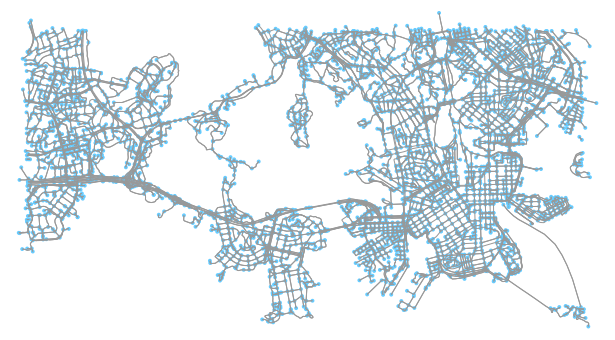

(<Figure size 775.196x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6f3b021cd0>)

In [15]:
ox.plot_graph(G)

As we can see, we have now a bit larger graph than before, and we can make longer trips. 

- Let's find the fastest route from Otaniemi campus to Helsinki city center campus using the midday impedance:

In [16]:
# Addresses
# Origin
orig_address = "Otakaari 12, Espoo"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Fabianinkatu 33, Helsinki"
dest_y, dest_x = ox.geocode(dest_address) 

In [17]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.get_nearest_node(G, point=(orig_y, orig_x), method='haversine', return_dist=True)
dest_node_id, dist_to_dest = ox.get_nearest_node(G, point=(dest_y, dest_x), method='haversine', return_dist=True)

In [18]:
# 2. Calculate the shortest paths by car during midday 
midday_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='Keskpva_aa')

# Get also the actual travel time (summarize)
midday_t = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='Keskpva_aa')

Plotting with custom weight attributes in OSMnx is currently not possible. Hence, we need to modify slightly the plotting functions, so that we can easily plot our paths:

In [26]:
def node_list_to_coordinate_lines(G, node_list, use_geom=True, weight_col='length'):
    """Obtained from OSMnx with custom weight_col."""
    edge_nodes = list(zip(node_list[:-1], node_list[1:]))
    lines = []
    for u, v in edge_nodes:
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), key=lambda x: x[weight_col])

        # if it has a geometry attribute (ie, a list of line segments)
        if 'geometry' in data and use_geom:
            # add them to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
    return lines

def plot_graph_route(G, route, weight_col='length', bbox=None, fig_height=6, fig_width=None,
                     margin=0.02, bgcolor='w', axis_off=True, show=True,
                     save=False, close=True, file_format='png', filename='temp',
                     dpi=300, annotate=False, node_color='#999999',
                     node_size=15, node_alpha=1, node_edgecolor='none',
                     node_zorder=1, edge_color='#999999', edge_linewidth=1,
                     edge_alpha=1, use_geom=True, origin_point=None,
                     destination_point=None, route_color='r', route_linewidth=4,
                     route_alpha=0.5, orig_dest_node_alpha=0.5,
                     orig_dest_node_size=100, orig_dest_node_color='r',
                     orig_dest_point_color='b'):
    """
    Modified from OSMnx with custom weight_col, see: 
    """
    from matplotlib.collections import LineCollection

    # plot the graph but not the route
    fig, ax = ox.plot_graph(G, bbox=bbox, fig_height=fig_height, fig_width=fig_width,
                         margin=margin, axis_off=axis_off, bgcolor=bgcolor,
                         show=False, save=False, close=False, filename=filename,
                         dpi=dpi, annotate=annotate, node_color=node_color,
                         node_size=node_size, node_alpha=node_alpha,
                         node_edgecolor=node_edgecolor, node_zorder=node_zorder,
                         edge_color=edge_color, edge_linewidth=edge_linewidth,
                         edge_alpha=edge_alpha, use_geom=use_geom)

    # the origin and destination nodes are the first and last nodes in the route
    origin_node = route[0]
    destination_node = route[-1]

    if origin_point is None or destination_point is None:
        # if caller didn't pass points, use the first and last node in route as
        # origin/destination
        origin_destination_lats = (G.nodes[origin_node]['y'], G.nodes[destination_node]['y'])
        origin_destination_lons = (G.nodes[origin_node]['x'], G.nodes[destination_node]['x'])
    else:
        # otherwise, use the passed points as origin/destination
        origin_destination_lats = (origin_point[0], destination_point[0])
        origin_destination_lons = (origin_point[1], destination_point[1])
        orig_dest_node_color = orig_dest_point_color

    # scatter the origin and destination points
    ax.scatter(origin_destination_lons, origin_destination_lats, s=orig_dest_node_size,
               c=orig_dest_node_color, alpha=orig_dest_node_alpha, edgecolor=node_edgecolor, zorder=4)

    # plot the route lines
    lines = node_list_to_coordinate_lines(G, route, use_geom, weight_col)

    # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors=route_color, linewidths=route_linewidth, alpha=route_alpha, zorder=3)
    ax.add_collection(lc)

    # save and show the figure as specified
    fig, ax = ox.save_and_show(fig, ax, save, show, close, filename, file_format, dpi, axis_off)
    return fig, ax

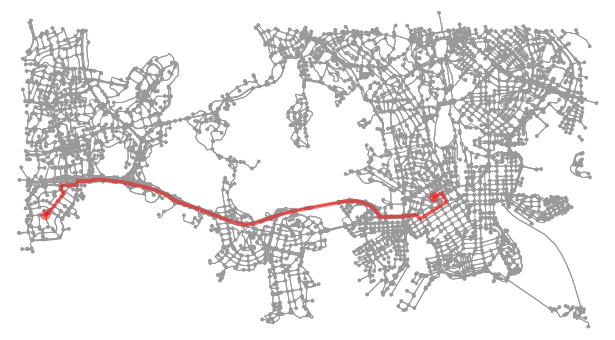

Text(0.5, 0, 'Drive time  19.3 minutes.')

In [29]:
# Let's plot our path with the custom functions
# Visualize static map
fig, ax = plot_graph_route(G, midday_path, weight_col='Keskpva_aa')

# Add the travel time as title
ax.set_xlabel("Drive time {t: .1f} minutes.".format(t=midday_t))